In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
from dataset import Paintings

from torchvision import transforms, datasets
import random
import torch
from pytorch_metric_learning.utils import logging_presets
from pytorch_metric_learning import losses, miners, samplers, distances, testers
import record_keeper
import torchvision.models as models
import torch.nn as nn
from tqdm import tqdm
import logging
import os
from functools import partial
import pandas as pd
from torch.utils.data import Dataset
import torch.optim as optim
import copy
import numpy as np
import cv2
from artist import Artist

In [3]:
torch.cuda.empty_cache()

In [4]:
logging.getLogger().setLevel(logging.INFO)

device = torch.device("cuda")

In [56]:
batch_size = 512

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [6]:
train_dataset = Paintings(is_train=True, transforms=train_transform)
test_dataset = Paintings(is_train=False, transforms=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [61]:
model = models.resnet18(pretrained=True)
parameters = model.fc.in_features
model.fc = nn.Linear(parameters, 128)

In [62]:
model = model.to(device)

In [59]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

distance = distances.LpDistance()
miner = miners.DistanceWeightedMiner(distance=distance)
margin_loss = losses.MarginLoss(distance=distance)

In [10]:
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)

In [11]:
def evaluate_emb(emb, labels, distance, k):
    d_mat = distance(emb)
    d_mat = d_mat.cpu().numpy()
    labels = labels.cpu().numpy()
    
    correct, cnt = 0.0, 0.0
    for i in range(emb.shape[0]):
        d_mat[i, i] = 1e10
        nns = np.argsort(d_mat[i])[:k]
        if any(labels[i] == labels[nn] for nn in nns):
            correct += 1
        cnt += 1
    accs = correct/cnt
    return accs

def test(test_dataset, distance, model, k):
    model.eval()
    test_embeddings, test_labels = get_all_embeddings(test_dataset, model)
    return evaluate_emb(test_embeddings, test_labels, distance, k)

In [12]:
def train(model, train_loader, test_dataset,
          miner, loss_function,
          optimizer,
          distance,
          k, num_epochs=100, scheduler=None):
    
    print(test(test_dataset, distance, model, k))
    loss_history = []
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epochs):
        model.train()
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        batch_loss = []
        avg_loss = 0
        
        pbar = tqdm(train_loader)
        for data, labels in pbar:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            embeddings = model(data)
            embeddings = nn.functional.normalize(embeddings)
            indices_tuple = miner(embeddings, labels)
            loss = loss_function(embeddings, labels, indices_tuple)
            batch_loss.append(float(loss))
            loss.backward()
            optimizer.step()
        if scheduler is not None:
            scheduler.step()
        avg_loss = np.mean(batch_loss)
        print(float(avg_loss))
        
        loss_history.append(float(avg_loss))
        
        
        acc = test(test_dataset, distance, model, k)
        print("Epoch %s"%epoch)
        print("Accuracy %s"%acc)
        
        if acc > best_acc:
            best_acc = acc
            torch.save(model, 'margin_wts_128_adam.pt')
   
    return loss_history, best_acc
            

In [ ]:
loss, best_acc, best_model_wts = train(model, train_loader, test_dataset, miner, margin_loss, optimizer, distance, 1, 100)

  0%|          | 0/42 [00:00<?, ?it/s]

0.6025316455696202


  0%|          | 0/99 [00:00<?, ?it/s]

0.2808310545626141


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 0
Accuracy 0.5642405063291139


  0%|          | 0/99 [00:00<?, ?it/s]

0.28038603918892996


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 1
Accuracy 0.5632911392405063


  0%|          | 0/99 [00:00<?, ?it/s]

0.2800327298187074


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 2
Accuracy 0.5645569620253165


  0%|          | 0/99 [00:00<?, ?it/s]

0.28107091784477234


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 3
Accuracy 0.5645569620253165


  0%|          | 0/99 [00:00<?, ?it/s]

0.2795592404547192


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 4
Accuracy 0.5636075949367089


  0%|          | 0/99 [00:00<?, ?it/s]

0.2789165519532703


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 5
Accuracy 0.5661392405063291


  0%|          | 0/99 [00:00<?, ?it/s]

0.280157045239494


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 6
Accuracy 0.5632911392405063


  0%|          | 0/99 [00:00<?, ?it/s]

0.2805563310782115


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 7
Accuracy 0.5664556962025317


  0%|          | 0/99 [00:00<?, ?it/s]

0.28029139978545053


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 8
Accuracy 0.5661392405063291


  0%|          | 0/99 [00:00<?, ?it/s]

0.2798127957752773


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 9
Accuracy 0.5632911392405063


  0%|          | 0/99 [00:00<?, ?it/s]

0.28020107604208444


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 10
Accuracy 0.5655063291139241


  0%|          | 0/99 [00:00<?, ?it/s]

0.2799247517472222


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 11
Accuracy 0.5667721518987342


 21%|██▏       | 9/42 [00:15<01:15,  2.28s/it]

In [ ]:
model = torch.load('triplet_margin_0.2_wts_128_sgd.pt')
model.eval()

In [14]:
import faiss

In [ ]:
test(test_dataset, distance, model, 1)

In [15]:
index = faiss.IndexFlatL2(128)

In [16]:
emb, labels = get_all_embeddings(test_dataset, model) 

100%|██████████| 99/99 [00:12<00:00,  7.62it/s]


In [37]:
emb[0]

tensor([ 0.1278,  0.0850, -0.0873,  0.0461,  0.0343,  0.0669,  0.0776, -0.0909,
         0.0852, -0.0899, -0.0983, -0.1147, -0.1073,  0.1367,  0.0341, -0.0468,
         0.0760,  0.0729, -0.0794,  0.2070,  0.1511, -0.1513, -0.0954, -0.0648,
        -0.0185,  0.0108,  0.1785, -0.0116,  0.0267,  0.1259, -0.0806, -0.1614,
        -0.1090,  0.0608,  0.0098, -0.0117, -0.0217,  0.0799,  0.0450, -0.0504,
        -0.0463, -0.0163, -0.1434, -0.0596,  0.0174, -0.0232,  0.0524,  0.1697,
         0.0483,  0.1777, -0.0547,  0.0484, -0.0813, -0.1698,  0.0876, -0.0736,
         0.0692,  0.0590,  0.0527,  0.1247, -0.0506, -0.0504,  0.0045,  0.0517,
        -0.0320,  0.0674,  0.0109,  0.0603,  0.0600, -0.0806, -0.0591,  0.0423,
        -0.0630,  0.0828,  0.0785,  0.0153, -0.0303,  0.0104, -0.0107, -0.1832,
        -0.0288,  0.1205,  0.0153,  0.1307, -0.1622, -0.0282, -0.0075, -0.0750,
        -0.0244, -0.0265,  0.0436,  0.0861,  0.0715, -0.1266,  0.0344, -0.0424,
        -0.0202, -0.0833, -0.0728,  0.02

In [17]:
index.add(emb.cpu().numpy())

In [18]:
input_tensor = test_dataset[1][0]

In [19]:
input_batch = input_tensor.unsqueeze(0)

In [20]:
input_batch = input_batch.to(device)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [42]:
with torch.no_grad():
    output = model(input_batch)
    output = nn.functional.normalize(output)

In [43]:
output, emb[1]

(tensor([[-0.0443,  0.0382,  0.0748, -0.0228, -0.0721, -0.0321, -0.0910,  0.0847,
           0.2684, -0.0003, -0.0852, -0.0880, -0.1540, -0.1156, -0.1020,  0.1122,
          -0.0913,  0.0541,  0.1160,  0.0364,  0.0048,  0.0062,  0.0790, -0.1616,
           0.0450,  0.0373,  0.0423, -0.0318,  0.0289, -0.1300,  0.0103, -0.1409,
          -0.0305,  0.0329, -0.0993, -0.0719,  0.1041,  0.0771,  0.1105,  0.0392,
           0.1606,  0.0948, -0.0312,  0.1294,  0.0465,  0.1195, -0.0181,  0.2855,
           0.0716,  0.0166,  0.0383,  0.0335,  0.0264,  0.0843, -0.0191,  0.1085,
           0.0650, -0.1625, -0.0997,  0.1712, -0.0484,  0.0877,  0.0100,  0.0996,
           0.0459,  0.1605,  0.0277, -0.0898, -0.1538, -0.0545,  0.0500, -0.0744,
           0.1507, -0.1360, -0.0743,  0.1852,  0.0291, -0.0855, -0.0004,  0.0110,
           0.0474,  0.1141,  0.0785,  0.0588,  0.0307, -0.0578, -0.0094,  0.0344,
          -0.0210, -0.0224, -0.1535, -0.0097, -0.1050, -0.1529,  0.0818, -0.0499,
          -0.021

In [44]:
index.search(output.cpu().numpy(), 4)

(array([[9.4071088e-12, 6.6554594e-01, 8.0279344e-01, 8.2688808e-01]],
       dtype=float32),
 array([[   1,   53,   26, 1783]]))

In [53]:
images_path = test_dataset.data[test_dataset.data['label']==0].image_path.values[:10]

In [50]:
import matplotlib.pyplot as plt

In [48]:
import os
import cv2


def open_images(images_paths, cvt_color_mode=cv2.COLOR_BGR2RGB, read_unchanged=False):
    images = []
    for image_path in images_paths:
        try:
            if read_unchanged:
                img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
            else:
                img = cv2.imread(image_path)
        except (IOError, ValueError, IndexError) as e:
            print(e)
        else:
            if cvt_color_mode is not None:
                img = cv2.cvtColor(img, cvt_color_mode)

            images.append(img)

    return images


def save_images(images, folder_path=None, names=None):
    if folder_path is None:
        folder_path = os.path.abspath('')

    if names is None:
        names = ['{}.jpg'.format(i+1) for i in range(len(images))]

    images_paths = [os.path.join(folder_path, name) for name in names]

    for img, path in zip(images, images_paths):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(path, img)

    return images_paths

In [49]:
def plot_images(images, orientation='hor', figsize=(40, 10)):
    n_images = len(images)
    fig = plt.figure(1, figsize=figsize)
    
    for i, img in enumerate(images):
        if orientation == 'vert':
            fig.add_subplot(n_images, 1, i+1)
        elif orientation == 'hor':
            fig.add_subplot(1, n_images, i+1)

        plt.imshow(img)
        plt.axis('off')
        
    plt.show()

In [54]:
images = open_images(images_path)

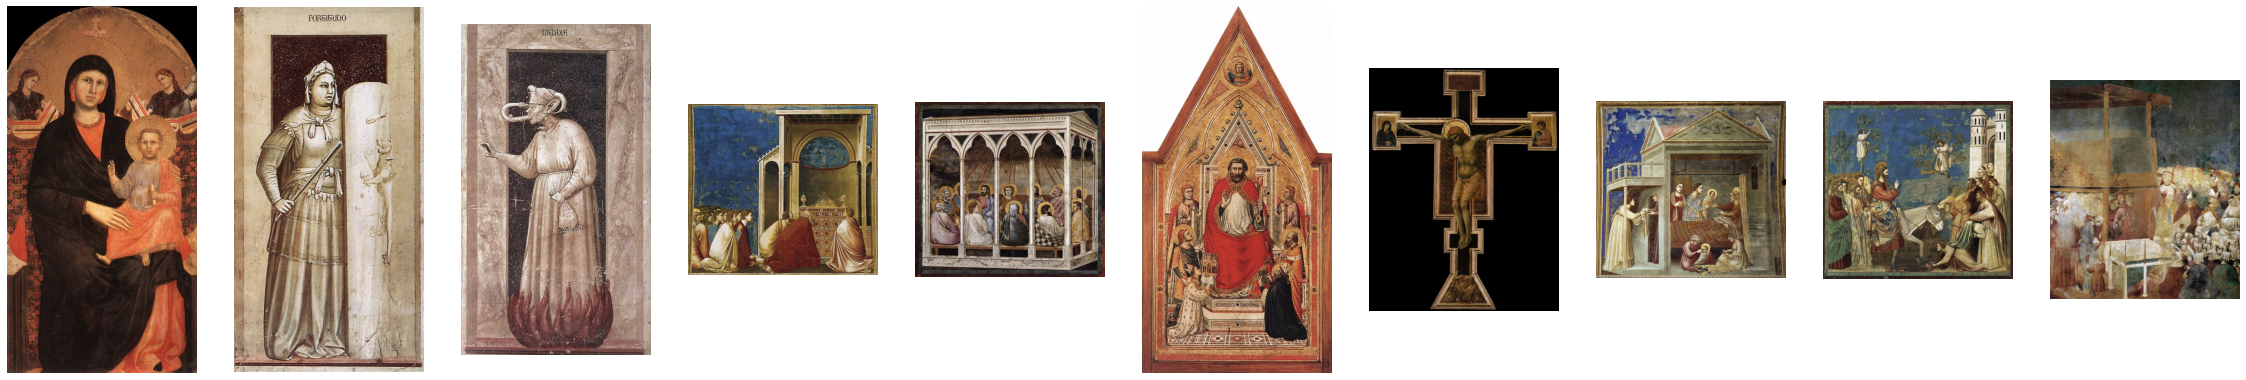

In [55]:
plot_images(images)

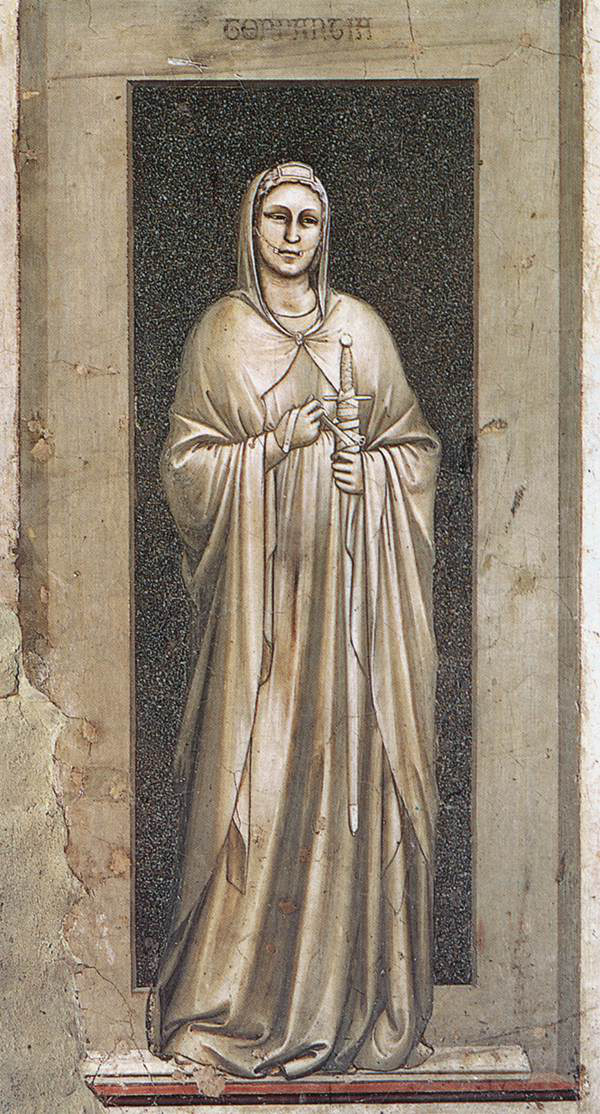

In [34]:
Image.open(test_dataset.data.iloc[53].image_path)

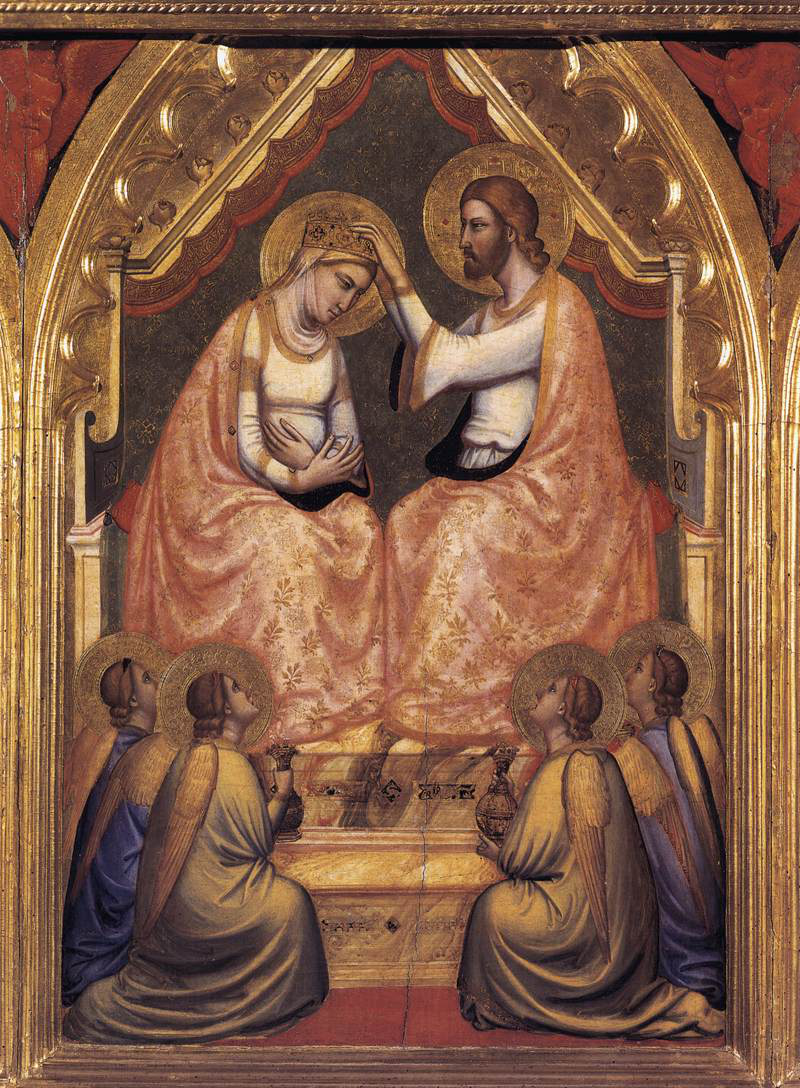

In [31]:
Image.open(test_dataset.data.iloc[26].image_path)

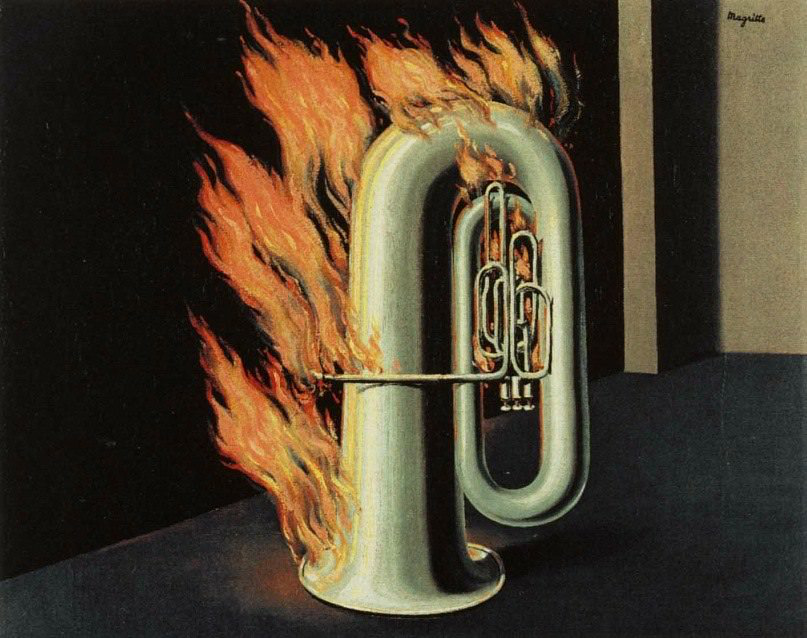

In [35]:
Image.open(test_dataset.data.iloc[1783].image_path)

In [ ]:
distance.compute_mat(emb, ref_emb=None)

In [ ]:
import urllib

In [ ]:
urllib.request.urlretrieve("https://i.pinimg.com/originals/f0/19/5e/f0195e953d9e34af23c308b7eb2470a4.jpg", "dog.jpg")

In [ ]:
art = Artist(transforms=test_transform)